# **EXPERIMENT 2**: 

This is pretty similar to Experiment 1 except it uses GloVe word embeddings.

This uses the same dataset, Emotions dataset for NLP, as Experiment 1.

## Import Packages

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install text_hammer 
import text_hammer as th
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
import tensorflow
from tensorflow.keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics

## Download Data

In [ ]:
df_train = pd.read_csv('../data/emotions-dataset-for-nlp/train.txt', header=None, sep =';', names=['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('../data/emotions-dataset-for-nlp/test.txt', header=None, sep =';', names=['Input','Sentiment'], encoding='utf-8')
df_val = pd.read_csv('../data/emotions-dataset-for-nlp/val.txt',header=None, sep=';', names=['Input','Sentiment'], encoding='utf-8')
df_train.head()

Input Sentiment
0                            i didnt feel humiliated   sadness
1  i can go from feeling so hopeless to so damned...   sadness
2   im grabbing a minute to post i feel greedy wrong     anger
3  i am ever feeling nostalgic about the fireplac...      love
4                               i am feeling grouchy     anger

## Try a text preprocessing package

In [ ]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x: str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x))
    return(df)
  
df_cleaned_train = text_preprocessing(df_train, 'Input')
df_cleaned_train.head()

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

Input Sentiment
0                            i do not feel humiliate   sadness
1  i can go from feel so hopeless to so damned ho...   sadness
2      i m grab a minute to post i feel greedy wrong     anger
3  i am ever feel nostalgic about the fireplace i...      love
4                                  i am feel grouchy     anger

In [ ]:
df_cleaned_train['Sentiment'] = df_cleaned_train.Sentiment.replace({'joy': 0,'anger': 1,'love': 2,'sadness': 3,'fear': 4,'surprise': 5})
df_test['Sentiment'] = df_test.Sentiment.replace({'joy': 0,'anger': 1,'love': 2,'sadness': 3,'fear': 4,'surprise': 5})
df_val['Sentiment'] = df_val.Sentiment.replace({'joy': 0,'anger': 1,'love': 2,'sadness': 3,'fear': 4,'surprise': 5})

In [ ]:
y_train = to_categorical(df_cleaned_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)

In [ ]:
num_words = 10000
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([df_cleaned_train['Input'], df_test.Input], axis=0)
tokenizer.fit_on_texts(df_total)

In [ ]:
X_train=tokenizer.texts_to_sequences(df_cleaned_train['Input'])
X_train_pad=pad_sequences(X_train, maxlen=300, padding='post')
X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen=300, padding='post')
X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen=300, padding='post')

## Word Embeddings

In [ ]:
!pip install gensim
import gensim.downloader as api
glove_gensim = api.load('glove-wiki-gigaword-100')

In [ ]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words, vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words:
        if word in glove_gensim.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

## Model

In [ ]:
EMBEDDING_DIM = 100
class_num = 6

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=EMBEDDING_DIM, input_length=X_train_pad.shape[1], weights=[gensim_weight_matrix], trainable=False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dense(class_num, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./exp-2/model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

## Training

In [ ]:
history_embedding = model.fit(X_train_pad, y_train, epochs=25, batch_size=120, validation_data=(X_val_pad, y_val), verbose=1, callbacks=[es, mc])

Epoch 1/25
134/134 [==============================] - ETA: 0s - loss: 1.4309 - accuracy: 0.4468
Epoch 00001: val_accuracy improved from -inf to 0.56000, saving model to ./drive/MyDrive/eecs595-final-project/exp-2/model.h5
134/134 [==============================] - 1290s 10s/step - loss: 1.4309 - accuracy: 0.4468 - val_loss: 1.1818 - val_accuracy: 0.5600
Epoch 2/25
134/134 [==============================] - ETA: 0s - loss: 1.1059 - accuracy: 0.5899
Epoch 00002: val_accuracy improved from 0.56000 to 0.66150, saving model to ./drive/MyDrive/eecs595-final-project/exp-2/model.h5
134/134 [==============================] - 1177s 9s/step - loss: 1.1059 - accuracy: 0.5899 - val_loss: 0.9191 - val_accuracy: 0.6615
Epoch 3/25
134/134 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.6877
Epoch 00003: val_accuracy improved from 0.66150 to 0.76900, saving model to ./drive/MyDrive/eecs595-final-project/exp-2/model.h5
134/134 [==============================] - 1162s 9s/step - lo

## Results

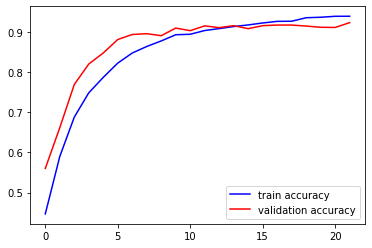

In [ ]:
plt.plot(history_embedding.history['accuracy'], c='b', label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'], c='r', label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
y_true = np.argmax(y_test, axis=1)
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       645
           1       0.92      0.89      0.90       285
           2       0.89      0.72      0.80       196
           3       0.94      0.93      0.94       583
           4       0.92      0.87      0.90       237
           5       0.67      0.81      0.73        54

    accuracy                           0.91      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.91      0.91      0.91      2000



In [ ]:
model.save('./exp-2/saved-model')

INFO:tensorflow:Assets written to: ./drive/MyDrive/eecs595-final-project/exp-2/saved-model/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/eecs595-final-project/exp-2/saved-model/assets


In [ ]:
loaded_model = tf.keras.models.load_model('./exp-2/saved-model')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 200)         160800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 300, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 400)         641600    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 300, 400)          0